In [2]:
import pandas as pd
import numpy as np

import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

import seaborn as sns
sns.set(rc={'figure.figsize':(22, 12)}, font_scale=3)
sns.set_style(style='whitegrid')

from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from pathlib import Path

# MDI Hurricanes Dataset

In [2]:
df_wave_height = pd.read_pickle('../real_data/MDI_datasets/hurricane/df_wave_height.pickle')
regions_df = pd.read_pickle('../real_data/MDI_datasets/hurricane/regions_df.pickle')
regions_df

,region_id,start,end,start_timestamp,end_timestamp,length,unix_start,unix_end
0,0,3432,3600,2012-10-22,2012-10-29,169,1.350864e+09,1.351469e+09
1,1,3192,3336,2012-10-12,2012-10-18,145,1.350000e+09,1.350518e+09
2,2,1968,2040,2012-08-22,2012-08-25,73,1.345594e+09,1.345853e+09


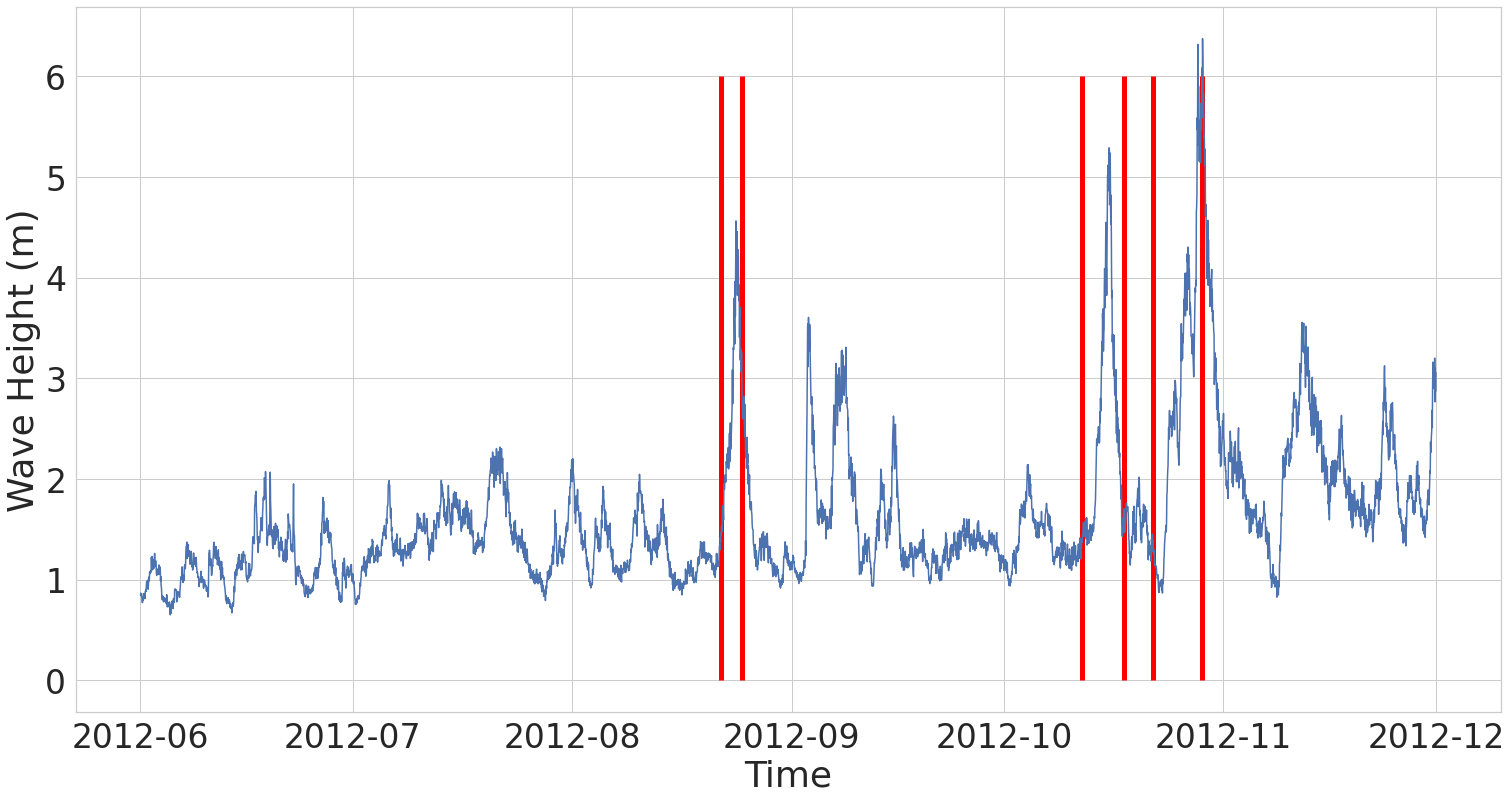

In [3]:
plt.plot(df_wave_height['timestamp'].values, df_wave_height['measure'].values, label='Wave Height (m)')
plt.xlabel('Time');plt.ylabel('Wave Height (m)');plt.tight_layout()
plt.vlines(regions_df['start_timestamp'], 0, 6, color='red', linewidth=5)
plt.vlines(regions_df['end_timestamp'], 0, 6, color='red', linewidth=5)
plt.savefig('figures/experiments/real_data/hurricane/wave_height_with_vlines.svg')

# KPI Dataset

## Dataset Pre-Processing

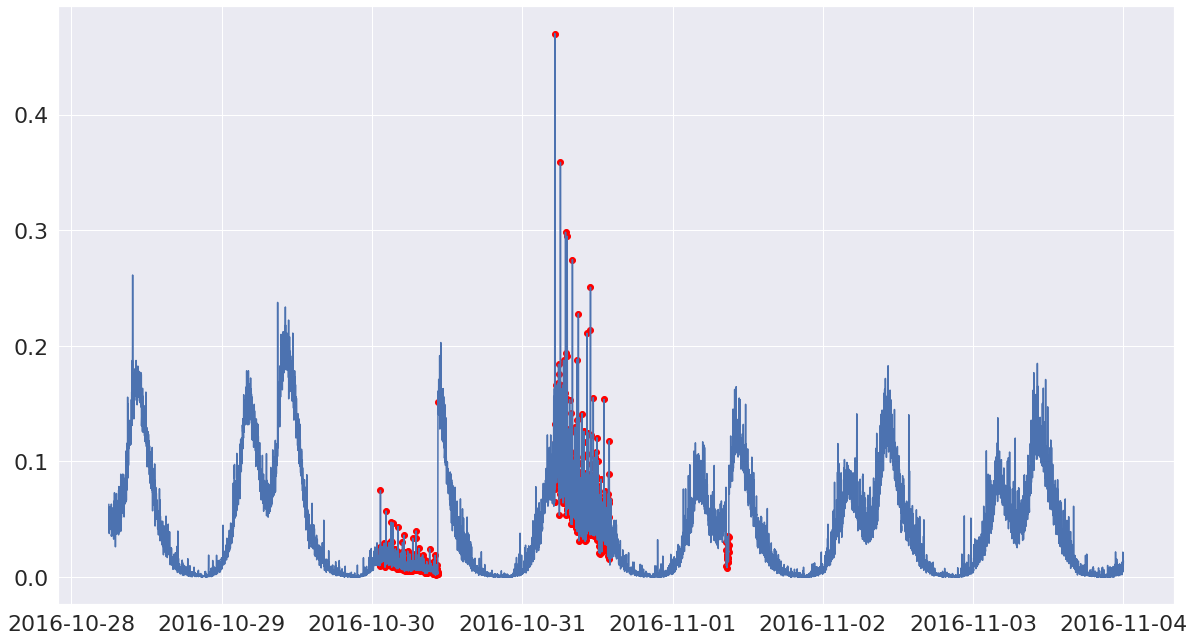

In [3]:
df = pd.read_csv('motivating_figures_data/phase2_train/phase2_train.csv')
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

df = df[df['date']>='2016-10-28 06:00:00']
df = df[df['date']<='2016-11-03 23:59:00']

label1_df = df[df['label']>0]
plt.plot(df['date'], df['value'])
plt.scatter(label1_df['date'], label1_df['value'], color='red')

In [4]:
df = df[['date', 'value']]
df = df.reset_index(drop=True)
df = df.rename(columns={"date": "timestamp", "value": 'measure'})
df.to_pickle('../real_data/KPI_dataset/df.pickle')

# Covert data to csv to feed as input for MDI
df.to_csv('../libmaxdiv/experiments/kpi.csv', index=False)
df

,timestamp,measure
0,2016-10-28 06:00:00,0.062999
1,2016-10-28 06:01:00,0.048385
2,2016-10-28 06:02:00,0.051526
3,2016-10-28 06:03:00,0.046550
4,2016-10-28 06:04:00,0.037701
...,...,...
9700,2016-11-03 23:55:00,0.005920
9701,2016-11-03 23:56:00,0.005622
9702,2016-11-03 23:57:00,0.007355
9703,2016-11-03 23:58:00,0.011283


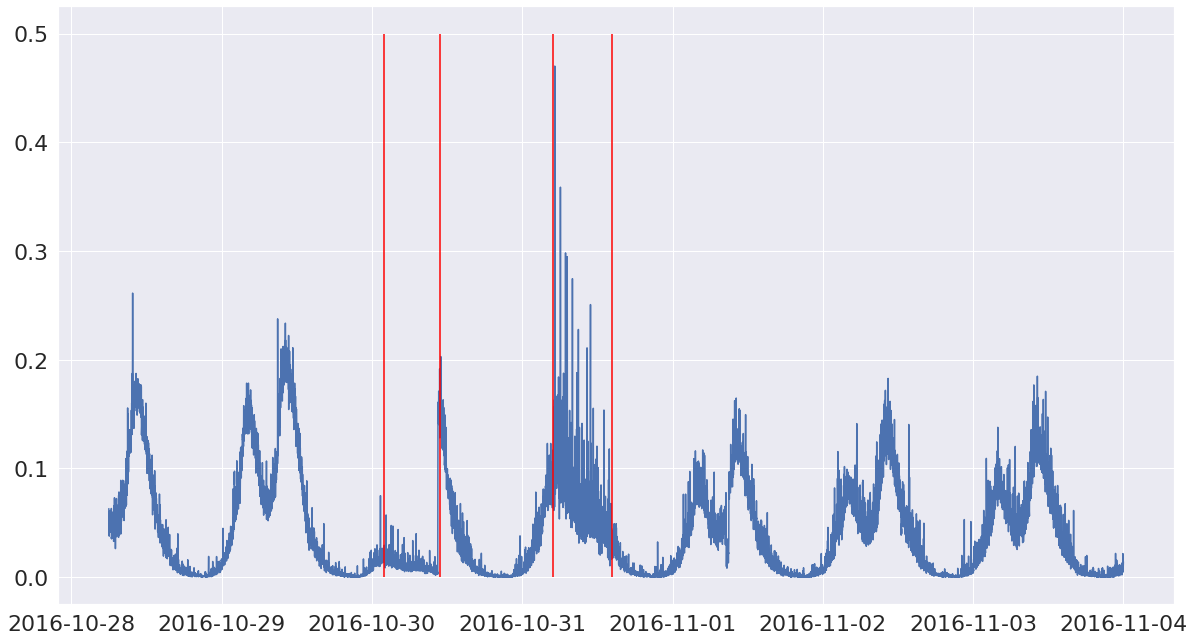

In [5]:
# Specify the anomalous regions
regions = [
    datetime.datetime(2016,10,30,2,0,0), datetime.datetime(2016,10,30,10,50,0),
    datetime.datetime(2016,10,31,4,55,0), datetime.datetime(2016,10,31,14,20,0)
]

plt.plot(df['timestamp'], df['measure'])
plt.vlines(regions, ymin=0, ymax=0.5, color='red',zorder=20)

In [6]:
regions = [
    [datetime.datetime(2016,10,30,2,0,0), datetime.datetime(2016,10,30,10,50,0)],
    [datetime.datetime(2016,10,31,4,55,0), datetime.datetime(2016,10,31,14,20,0)]
]

regions_df = pd.DataFrame(columns=['region_id',	'start', 'end', 'start_timestamp', 'end_timestamp', 'length'])
for i in range(len(regions)):
    start = df[df['timestamp'] == regions[i][0]].index.values[0]
    end = df[df['timestamp'] == regions[i][1]].index.values[0]
    start_timestamp = regions[i][0]
    end_timestamp = regions[i][1]
    
    region = [i, start, end, start_timestamp, end_timestamp, end-start+1]
    regions_df.loc[len(regions_df.index)] = region

regions_df['unix_start'] = regions_df['start_timestamp'].apply(lambda x: x.timestamp())
regions_df['unix_end'] = regions_df['end_timestamp'].apply(lambda x: x.timestamp())
regions_df.to_pickle('../real_data/KPI_dataset/regions_df.pickle')
regions_df

,region_id,start,end,start_timestamp,end_timestamp,length,unix_start,unix_end
0,0,2633,3163,2016-10-30 02:00:00,2016-10-30 10:50:00,531,1.477793e+09,1.477825e+09
1,1,4248,4813,2016-10-31 04:55:00,2016-10-31 14:20:00,566,1.477890e+09,1.477924e+09


## Evaluation

In [7]:
def get_range_based_eval_scores(real_ranges, predicted_ranges, predicted_ranges_outlier_bounds):
    precision = utils.range_based_precision(real_ranges, predicted_ranges)
    recall = utils.range_based_recall(real_ranges, predicted_ranges)
    f1_score = utils.compute_f1_score(precision, recall) 
    
    precision_outlier_bounds = utils.range_based_precision(real_ranges, predicted_ranges_outlier_bounds)
    recall_precision_outlier_bounds = utils.range_based_recall(real_ranges, predicted_ranges_outlier_bounds)
    f1_score_outlier_bounds = utils.compute_f1_score(precision_outlier_bounds, recall_precision_outlier_bounds)

    print("Full Bounds:")
    print("Precision:", precision, 'Recall:', recall, 'F1-Score:', f1_score)
    print("\nOutlier Bounds:")
    print("Precision:", precision_outlier_bounds, 'Recall:', recall_precision_outlier_bounds, 'F1-Score:', f1_score_outlier_bounds)


def get_eval_scores(real_ranges, predicted_ranges):
    precision = utils.range_based_precision(real_ranges, predicted_ranges)
    recall = utils.range_based_recall(real_ranges, predicted_ranges)
    f1_score = utils.compute_f1_score(precision, recall) 
    return precision, recall, f1_score

def get_predicted_ranges(clusters_df):
    '''
    Returns two lists. The predicted_ranges list and the predicted_ranges_outlier_bounds list
    '''
    predicted_ranges = []
    predicted_ranges_outlier_bounds = []
    for _, predicted_range_row  in clusters_df.iterrows():
        predicted_range = [predicted_range_row['start'], predicted_range_row['end']]
        predicted_range_outlier_bound = [predicted_range_row['point_start'], predicted_range_row['point_end']]
        predicted_ranges.append(predicted_range)
        predicted_ranges_outlier_bounds.append(predicted_range_outlier_bound)
    return predicted_ranges, predicted_ranges_outlier_bounds

In [8]:
real_ranges = []
for _, real_range_row in regions_df.iterrows():
    real_range = [real_range_row['unix_start'], real_range_row['unix_end']]
    real_ranges.append(real_range)

### MDI

In [9]:
mdi_regions = pd.read_csv('../real_data/KPI_dataset/evaluation/MDI/mdi_top10_regions_400_600.csv')
mdi_regions['Start'] = pd.to_datetime(mdi_regions['Start'])
mdi_regions['End'] = pd.to_datetime(mdi_regions['End'])
mdi_regions['unix_start'] = mdi_regions['Start'].apply(lambda x: x.timestamp())
mdi_regions['unix_end'] = mdi_regions['End'].apply(lambda x: x.timestamp())
mdi_regions

,Start,End,Score,unix_start,unix_end
0,2016-10-31 04:00:00,2016-10-31 14:00:00,3325.781237,1.477886e+09,1.477922e+09
1,2016-11-01 16:57:00,2016-11-02 00:17:00,1159.966390,1.478019e+09,1.478046e+09
2,2016-10-30 16:07:00,2016-10-30 23:28:00,1128.762039,1.477844e+09,1.477870e+09
3,2016-10-31 15:43:00,2016-11-01 00:42:00,1102.538597,1.477929e+09,1.477961e+09
4,2016-11-03 16:18:00,2016-11-03 23:53:00,1068.040387,1.478190e+09,1.478217e+09
5,2016-10-29 16:22:00,2016-10-30 01:11:00,1064.022835,1.477758e+09,1.477790e+09
6,2016-10-28 17:04:00,2016-10-29 00:09:00,992.317561,1.477674e+09,1.477700e+09
7,2016-11-02 16:15:00,2016-11-02 23:37:00,897.609425,1.478103e+09,1.478130e+09
8,2016-10-30 01:25:00,2016-10-30 10:31:00,755.316655,1.477791e+09,1.477823e+09
9,2016-10-29 02:55:00,2016-10-29 12:55:00,750.857350,1.477710e+09,1.477746e+09


In [10]:
mdi_regions = mdi_regions.head(3)
predicted_ranges = []
for _, predicted_range_row  in mdi_regions.iterrows():
    predicted_range = [predicted_range_row['unix_start'], predicted_range_row['unix_end']]
    predicted_ranges.append(predicted_range)

mdi_precision = utils.range_based_precision(real_ranges, predicted_ranges)
mdi_recall = utils.range_based_recall(real_ranges, predicted_ranges)
mdi_f1_score = utils.compute_f1_score(mdi_precision, mdi_recall) 
print("Precision:", mdi_precision, 'Recall:', mdi_recall, 'F1-Score:', mdi_f1_score)

Precision: 0.30303030303030304 Recall: 0.5 F1-Score: 0.37735849056603776


### ISJ

In [11]:
clusters_df = pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ/clusters_df.pickle').sort_values(by='area', ascending=False).head(2)
predicted_ranges, predicted_ranges_outlier_bounds = get_predicted_ranges(clusters_df)
get_range_based_eval_scores(real_ranges, predicted_ranges, predicted_ranges_outlier_bounds)

Full Bounds:
Precision: 1.0 Recall: 0.3 F1-Score: 0.4615384615384615

Outlier Bounds:
Precision: 1.0 Recall: 0.3 F1-Score: 0.4615384615384615


### ISJ (Adjusted Local Minima)

In [12]:
clusters_df = pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ_adj_local_min/clusters_df.pickle').sort_values(by='area', ascending=False).head(2)
predicted_ranges, predicted_ranges_outlier_bounds = get_predicted_ranges(clusters_df)
get_range_based_eval_scores(real_ranges, predicted_ranges, predicted_ranges_outlier_bounds)

Full Bounds:
Precision: 0.8194444444444444 Recall: 0.8388888888888889 F1-Score: 0.8290526707612135

Outlier Bounds:
Precision: 0.9166666666666667 Recall: 0.8138888888888889 F1-Score: 0.8622257891920814


### Density Figures

In [18]:
def get_timeseries_and_density_figure(df, density, clusters, k):
    df = df.sort_values(by='timestamp')

    k_clusters = clusters.sort_values(by='area', ascending=False).head(k).reset_index()

    # Plot the Figure
    fig, axs = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0)

    axs[0].plot(df['unix_time'], df['measure'])
    axs[0].scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
    axs[0].scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
    axs[0].set_ylabel('Measure');axs[0].legend()

    # Plot the alert regions
    for _, alert in k_clusters.iterrows():
        axs[0].add_patch(patches.Rectangle((alert['start'], 0), width=alert['end']-alert['start'], height=0.5, linewidth=0, color='yellow', zorder=10, alpha=0.40))

    axs[1].plot(density['unix_time'], density['density'])
    axs[1].set_ylabel('Density');axs[1].set_xlabel('Unix Time')
    for idx, alert in k_clusters.iterrows():
        axs[1].add_patch(patches.Rectangle((alert['start'], 0), width=alert['end']-alert['start'], height=density['density'].max(), linewidth=0, color='yellow', zorder=10, alpha=0.40))
        x_loc = alert['start'] + (alert['end'] - alert['start'])/2
        axs[1].text(x=x_loc, y=density['density'].max(), s=str(idx+1), fontsize=12, color='red', horizontalalignment='center')

    plt.tight_layout()



#### ISJ

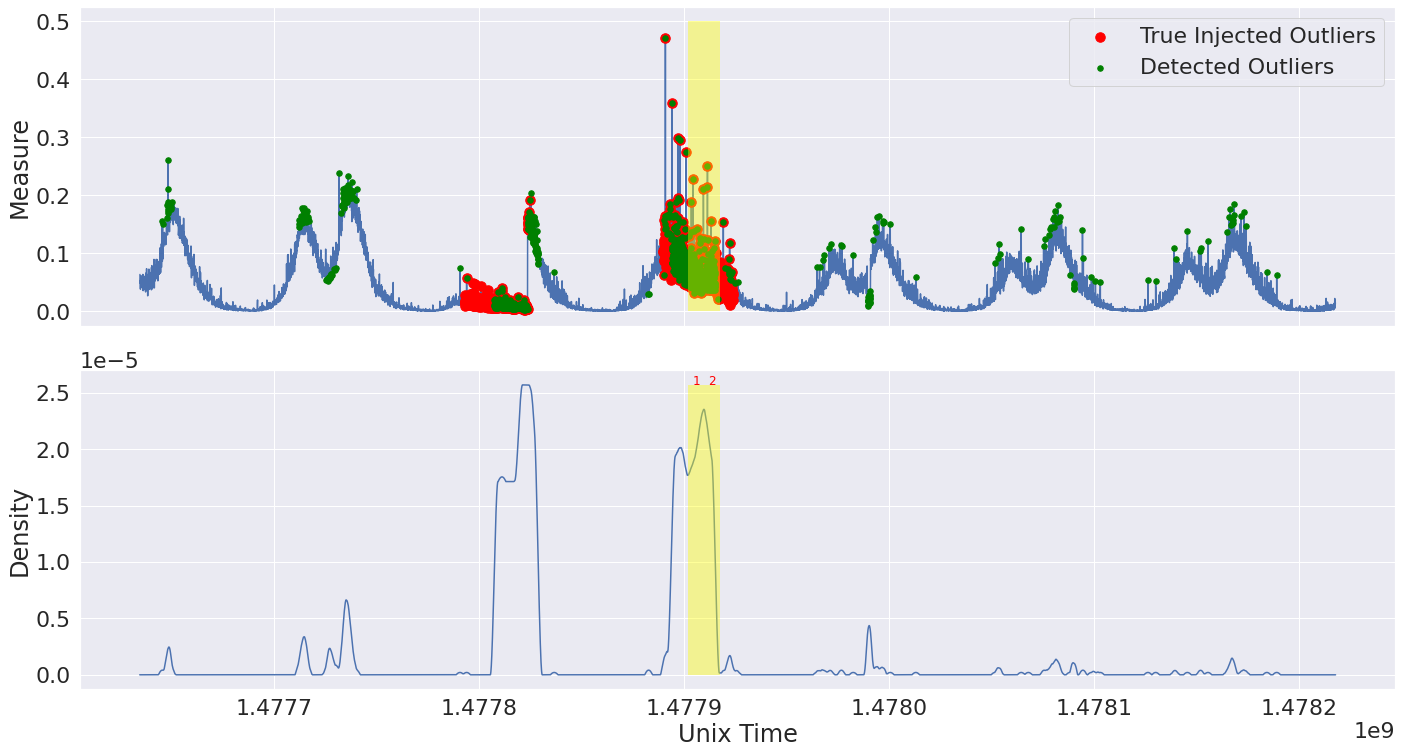

In [20]:
df=pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ/df.pickle')
density_df=pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ/density_df.pickle')
clusters_df = pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ/clusters_df.pickle').sort_values(by='area', ascending=False).head(2)
get_timeseries_and_density_figure(df=df, density=density_df, clusters=clusters_df, k=2)
plt.savefig('figures/experiments/real_data/KPI/isj_density_regions.svg')

#### ISJ (Adjusted Local Minima)

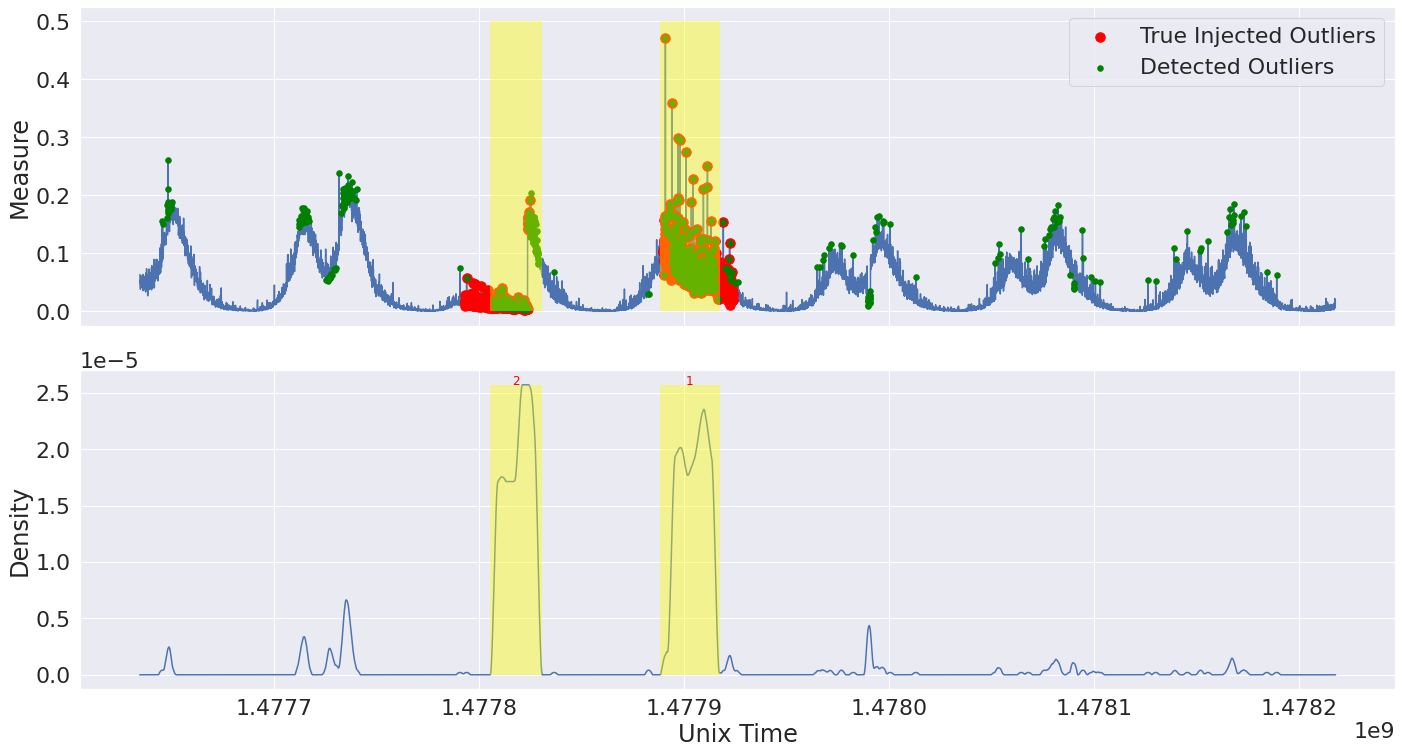

In [21]:
df=pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ_adj_local_min/df.pickle')
density_df=pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ_adj_local_min/density_df.pickle')
clusters_df = pd.read_pickle('../real_data/KPI_dataset/evaluation/ISJ_adj_local_min/clusters_df.pickle').sort_values(by='area', ascending=False).head(2)
get_timeseries_and_density_figure(df=df, density=density_df, clusters=clusters_df, k=2)
plt.savefig('figures/experiments/real_data/KPI/isj_adj_local_min_density_regions.svg')